In [1]:
# Importing libraries

import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import zipfile
from torch.utils.data import Dataset, DataLoader
from kaggle.api.kaggle_api_extended import KaggleApi
from torchvision import transforms
import tqdm
from sklearn.model_selection import train_test_split
import PIL
import random

In [2]:
# Choosing model parameters

competition = "dogs-vs-cats"

epochs = input("Number of Epochs? [5]")
if epochs.isdigit()==True and epochs.isdigit()!=0:
    epochs = int(epochs)
else:
    epochs = 5
print("Number of epochs set to:",epochs)

drop_rate = input("Dropout rate? [0%]")
if drop_rate.isdigit()==True:
    drop_rate = int(drop_rate)/100
else:
    drop_rate = 0
print("Dropout rate set to:", drop_rate*100,"%")

batch_size = input("Batch size? [96]")
if batch_size.isdigit()==True and int(batch_size)!=0:
    batch_size = int(batch_size)
else:
    batch_size = 96
print("Batch size set to:", batch_size)

num_workers = input("Number of workers? [10]")
if num_workers.isdigit()==True and int(num_workers)<0==False:
    num_workers = int(num_workers)
else:
    num_workers = 10
print("Number of workers set to:", num_workers)
num_workers

lr = input('Learning rate? [0.002]')
if lr!='0' and lr.replace('.','',1).isdigit()==True: lr = float(lr)
else: lr = 2e-3
print("Learning rate set to:",lr)


# Choosing dataset parameters

download_path = input("Download path for dataset zip file? [./]")
if os.path.isdir(download_path)==False:
    download_path = "./"
print("Download path set to:",download_path)

dataset_size = input('Size of dataset? [25000]')
if dataset_size.isdigit() and int(dataset_size)>0 and int(dataset_size)<=25000:
    dataset_size=int(dataset_size)
else: dataset_size=25000
print('Dataset size set to:',dataset_size)

train_percent = input('% of data used for training? [70]')
if train_percent.replace('.','',1).isdigit()== True and train_percent!='0': train_percent=int(train_percent)/100
else: train_percent = 0.7
valid_percent = input('% of data used for validation? [20]')
if valid_percent.replace('.','',1).isdigit()== True and valid_percent!='0': valid_percent=int(valid_percent)/100
else: valid_percent = 0.2
test_percent = 1-train_percent-valid_percent

train_val_test_split = (train_percent,valid_percent,test_percent)

print('Training : Validation : Testing ratio set to', int(train_percent*100), ":", int(valid_percent*100), ":", int(test_percent*100))

Number of epochs set to: 5
Dropout rate set to: 20.0 %
Batch size set to: 96
Number of workers set to: 10
Learning rate set to: 0.002
Download path set to: ./
Dataset size set to: 25000
Training : Validation : Testing ratio set to 80 : 10 : 9


In [3]:
# Using Kaggle API to download data

api = KaggleApi()
api.authenticate()

if competition+".zip" in os.listdir(download_path):
    print("***Dataset present at local path. Skipping download***")
else:
    print("Downloading dataset...")
    api.competition_download_files("dogs-vs-cats",path=download_path)
    print("Done")

***Dataset present at local path. Skipping download***


In [4]:
# Extracting Data 

print("Extracting dataset...")
dataset = zipfile.ZipFile(download_path+competition+".zip", 'r')
dataset.extractall(path=download_path)
print(len(dataset.namelist()),"files extracted \n")

train_dir = download_path+"train/"
print("Extracting training files...")
trainZip = zipfile.ZipFile(download_path+"train.zip", 'r')
print(len(trainZip.namelist())-1,"training images found") #Removing 1 from len(trainZip.namelist()) since train/ is counted
trainZip.extractall(path=download_path)

train_files = random.sample(os.listdir(train_dir),k = dataset_size)

# zipfile.ZipFile(download_path+"test1.zip", 'r').extractall(path=download_path) # if you'd like to extract test images as well (non-labeled)
# test_files = os.listdir(download_path+"test1")

# Cleaning up
for file in dataset.filelist:
    os.remove(file.filename)
# os.remove(dataset.filename) if you'd like to remove the original zip file from Kaggle as well

Extracting dataset...
3 files extracted 

Extracting training files...
25000 training images found


In [5]:
# Defining augmentations

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [6]:
# Creating dataset

class DogsVsCatsDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = val_transform):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = PIL.Image.open(os.path.join(self.dir, self.file_list[idx]))
        img = self.transform(img)
        img = np.array(img)
        if 'dog' in self.file_list[idx]:
            self.label = 1
        else:
            self.label = 0
        return img.astype('float32'), self.label


train_files, test_files = train_test_split(train_files, 
                                    test_size=train_val_test_split[2], 
                                    random_state=42
                                    )
train_files, valid_files = train_test_split(train_files,
                                    test_size=train_val_test_split[1]/train_val_test_split[0], 
                                    random_state=42
                                    )

TrainDataSet = DogsVsCatsDataset(train_files, dir = train_dir, mode='train', transform = train_transform)
TrainDataLoader = DataLoader(TrainDataSet, batch_size = batch_size, shuffle=True, num_workers=num_workers)

ValidDataSet = DogsVsCatsDataset(valid_files, dir = train_dir, mode='valid')
ValidDataLoader = DataLoader(ValidDataSet, batch_size = batch_size, shuffle=False, num_workers=num_workers)

TestDataSet = DogsVsCatsDataset(test_files, dir = train_dir, mode='test')
TestDataLoader = DataLoader(TestDataSet, batch_size = batch_size, shuffle=False, num_workers=num_workers)

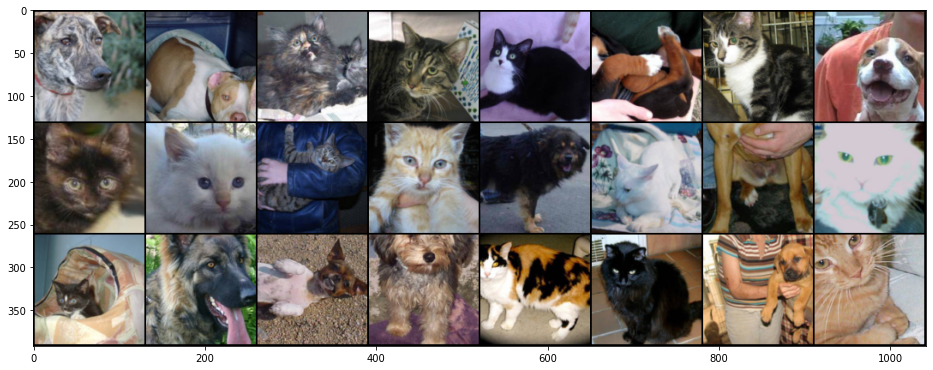

In [7]:
# Visualising to ensure augmentions/transformations done without errors

samples, labels = iter(TrainDataLoader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [8]:
# Defining model and training device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torchvision.models.densenet121(pretrained=True,drop_rate=drop_rate)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
model = model.to(device)

Epoch 1 / 5


Training: 100%|██████████| 206/206 [01:33<00:00,  2.20 Iterations/s]


 Total Loss: 69.7233, Accuracy: 87.3 %


Validating: 100%|██████████| 30/30 [00:04<00:00,  7.18 Iterations/s]


-----------------------------> Validation Loss: 8.9446, Accuracy: 87.0 %
Epoch 2 / 5


Training: 100%|██████████| 206/206 [01:34<00:00,  2.18 Iterations/s]


 Total Loss: 40.2480, Accuracy: 91.9 %


Validating: 100%|██████████| 30/30 [00:04<00:00,  7.18 Iterations/s]


-----------------------------> Validation Loss: 7.8317, Accuracy: 89.4 %
Epoch 3 / 5


Training: 100%|██████████| 206/206 [01:34<00:00,  2.18 Iterations/s]


 Total Loss: 31.6669, Accuracy: 93.5 %


Validating: 100%|██████████| 30/30 [00:04<00:00,  7.24 Iterations/s]


-----------------------------> Validation Loss: 12.5529, Accuracy: 86.0 %
Epoch 4 / 5


Training: 100%|██████████| 206/206 [01:33<00:00,  2.21 Iterations/s]


 Total Loss: 29.3327, Accuracy: 94.3 %


Validating: 100%|██████████| 30/30 [00:04<00:00,  7.29 Iterations/s]


-----------------------------> Validation Loss: 10.2847, Accuracy: 81.6 %
Epoch 5 / 5


Training: 100%|██████████| 206/206 [01:33<00:00,  2.20 Iterations/s]


 Total Loss: 27.2163, Accuracy: 94.5 %


Validating: 100%|██████████| 30/30 [00:04<00:00,  7.21 Iterations/s]


-----------------------------> Validation Loss: 7.7882, Accuracy: 91.1 %


Testing: 100%|██████████| 27/27 [00:03<00:00,  7.36 Iterations/s]


-----------------------------> Testing Accuracy: 91.7 %


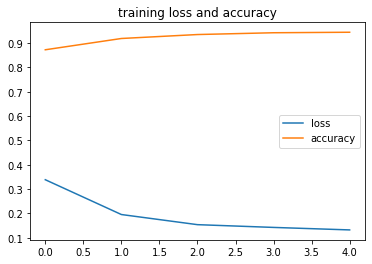

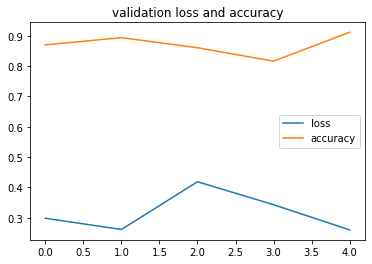

In [9]:
# Training

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
test_acc_list = []

for epoch in range(epochs):
    print("Epoch",epoch+1,"/",epochs)
    model.train()
    train_loss = 0
    train_acc = 0
    itr = 1
    tot_itr = len(TrainDataLoader)
    for samples, labels in tqdm.tqdm(TrainDataLoader, desc = "Training", unit = " Iterations"):
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        train_acc+= torch.mean(correct.float())
        torch.cuda.empty_cache()
        itr += 1
        
    train_loss_list.append(train_loss/tot_itr)
    train_acc_list.append(train_acc.item()/tot_itr)
    print(' Total Loss: {:.4f}, Accuracy: {:.1f} %'.format(train_loss, train_acc/tot_itr*100))

    model.eval()
    valid_loss=0
    valid_acc=0
    itr=1
    tot_itr = len(ValidDataLoader)
    for samples, labels in tqdm.tqdm(ValidDataLoader, desc = "Validating", unit = " Iterations"):
        with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            valid_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            valid_acc += torch.mean(correct.float())
            torch.cuda.empty_cache()
            itr += 1
            
    valid_loss_list.append(valid_loss/tot_itr)
    valid_acc_list.append(valid_acc.item()/tot_itr)
    print('-----------------------------> Validation Loss: {:.4f}, Accuracy: {:.1f} %'.format(valid_loss, valid_acc/tot_itr*100))

test_acc = 0
itr = 1
tot_itr = len(TestDataLoader)
for samples, labels in tqdm.tqdm(TestDataLoader, desc = "Testing", unit = " Iterations"):
        with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            test_acc += torch.mean(correct.float())
            torch.cuda.empty_cache()
            itr += 1
print('-----------------------------> Testing Accuracy: {:.1f} %'.format(test_acc/tot_itr*100))

plt.plot(train_loss_list, label='loss')
plt.plot(train_acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.show()

plt.plot(valid_loss_list, label='loss')
plt.plot(valid_acc_list, label='accuracy')
plt.legend()
plt.title('validation loss and accuracy')
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.show()